[tuto dipy](https://dipy.org/documentation/1.4.1./examples_built/tracking_introduction_eudx/#example-tracking-introduction-eudx)

In [1]:
# Import des modules
import numpy as np
from dipy.io.image import load_nifti, save_nifti
from dipy.io.gradients import read_bvals_bvecs
from dipy.core.gradients import gradient_table
import dipy.reconst.dti as dti
from dipy.data import get_fnames

# Télécharge des données HARDI
hardi_fname, hardi_bval_fname, hardi_bvec_fname = get_fnames('stanford_hardi')
data, affine = load_nifti(hardi_fname)
bvals, bvecs = read_bvals_bvecs(hardi_bval_fname, hardi_bvec_fname)
gtab = gradient_table(bvals, bvecs)

# Masque les données et estime les tenseurs
from dipy.segment.mask import median_otsu
data = data[:, :, 28:29, :]
maskdata, mask = median_otsu(data, vol_idx=range(10, 50), median_radius=3,
                             numpass=1, autocrop=True, dilate=2)
tenmodel = dti.TensorModel(gtab)
tenfit = tenmodel.fit(maskdata)

# Génère métriques dérivées (FA etc)
from dipy.reconst.dti import fractional_anisotropy, color_fa
FA = fractional_anisotropy(tenfit.evals)
FA[np.isnan(FA)] = 0
FA = np.clip(FA, 0, 1)
RGB = color_fa(FA, tenfit.evecs)
MD1 = dti.mean_diffusivity(tenfit.evals)

# Figure
from dipy.data import get_sphere
sphere = get_sphere('repulsion724')
from dipy.viz import window, actor
scene = window.Scene()
# evals = tenfit.evals
# evecs = tenfit.evecs
# cfa = RGB
# # boost the colors
# cfa *= 2
# cfa[cfa > 1] = 1
# scene.set_camera(
#                  position=(-100, 60, 75),
#                  focal_point=(0, 0, -75),
#                  view_up=(0, 0, 1)
#                 )
# scene.add(actor.tensor_slicer(evals, evecs, scalar_colors=cfa, sphere=sphere,
#                               scale=0.3))
# window.record(scene, n_frames=1, out_path='irm_diffusion/tensor-slice.png',
#               size=(800, 800))

# Figure zoom
# scene.clear()
evals = tenfit.evals[16:26, 54:64, :]
evecs = tenfit.evecs[16:26, 54:64, :]

# boost the colors
RGB *= 2
RGB[RGB>1] = 1
cfa = RGB[16:26, 54:64, :]
scene.set_camera(position=(-176.42, 118.52, 150),
                 focal_point=(0, 0, 75),
                 view_up=(0, 0, 1))
scene.add(actor.tensor_slicer(evals, evecs, scalar_colors=cfa, sphere=sphere,
                              scale=0.3))

print('Saving illustration as tensor_ellipsoids.png')
window.record(scene, n_frames=1, out_path='irm_diffusion/tensor-zoom.png',
              size=(600, 600))

  0%|          | 0/5578 [00:00<?, ? MB/s]

  0%|          | 0/1 [00:00<?, ? MB/s]

  0%|          | 0/1 [00:00<?, ? MB/s]

Saving illustration as tensor_ellipsoids.png


FileNotFoundError: [Errno 2] No such file or directory: 'irm_diffusion/tensor-zoom.png'

Text(0.5, 1.0, 'masque de la matière blanche')

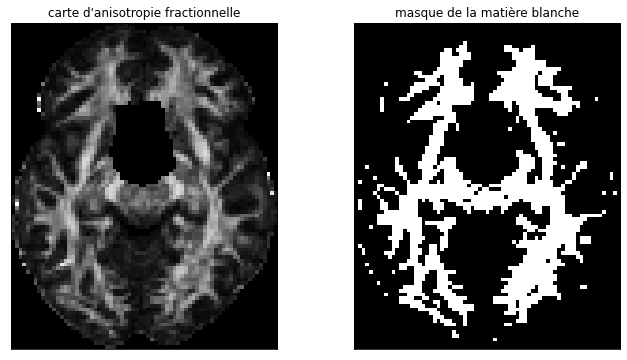

In [14]:
from matplotlib import pyplot as plt
MD = MD1
MD[mask==0] = 0
threshold_fa = 0.3
mask_wm = FA > threshold_fa


fig1, ax = plt.subplots(1, 2, figsize=(12, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

fig1.subplots_adjust(hspace=0.3, wspace=0.05)
ax.flat[0].imshow(np.squeeze(FA).T, origin='lower',
                  cmap='gray', vmin=0, vmax=1)
ax.flat[0].set_title('carte d\'anisotropie fractionnelle')
ax.flat[1].imshow(np.squeeze(mask_wm).T, origin='lower',
                  cmap='gray')
ax.flat[1].set_title('masque de la matière blanche')


In [19]:
data.shape

(81, 106, 1, 160)

In [16]:
from dipy.tracking import utils

seeds = utils.seeds_from_mask(mask_wm, affine, density=[2, 2, 2])

from dipy.tracking.stopping_criterion import ThresholdStoppingCriterion

stopping_criterion = ThresholdStoppingCriterion(FA, threshold_fa)

from dipy.direction import peaks_from_model
csa_peaks = peaks_from_model(tenfit, data, sphere,
                             relative_peak_threshold=.8,
                             min_separation_angle=45,
                             mask=mask_wm)


from dipy.tracking.local_tracking import LocalTracking
from dipy.tracking.streamline import Streamlines

# Initialization of LocalTracking. The computation happens in the next step.
streamlines_generator = LocalTracking(csa_peaks, stopping_criterion, seeds,
                                      affine=affine, step_size=.5)
# Generate streamlines object
streamlines = Streamlines(streamlines_generator)

ValueError: Mask is not the same shape as data.

In [9]:
evals = tenfit.evals[16:26, 54:64, :]
evecs = tenfit.evecs[16:26, 54:64, :]